In [1]:
import os
import sys

import numpy as np

from pstools.rambo import dot

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

2023-11-26 18:32:22.136357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training a Neural Network to approximate amplitudes from pre-generated data ##

The sqaured scattering amplitude (summed and averaged over colour) for $e^+e^- \to$ jets have been evaluated over a flat phase-space generated with the RAMBO algorithm. Various phase-space cuts for the separation of final state 'jets' have been applied using the JADE algorithm. Tree/zero-loop '0L' ($|A^{(0)}|^2$) and one-loop ($2{\rm Re}(A^{(0)*}A^{(1)}|$) amplitudes have been compute using the NJet C++ library (https://bitbucket.org/njet/njet/wiki/Home)

The data consists of 1M phase-space points for processes with 3 or 4 final state jets. The data is given in numpy '.npz' format generated using the 'numpy.savez' command and are labelled as

<code>data/NJdata_\<loop order\>_ee\<n\>j_d\<jade cut\>.npz</code>

where loop order=0L,1L, n=3,4 and jade cut=0.03, 0.02 and 0.01

The data files can be obtained from the url (using wget for example):

`wget http://personalpages.to.infn.it/~badger/njet-data/eejet_data.tar.gz`

# Aims #

To use the tensorflow library to make a simple approximation of the multi-variable amplitude function and test how good of an approximation we get. Try to determine how well we approximate the amplitude point-by-point correlates with the observable cross section

# Step 1: Separate amplitude data and train TensorFlow neural network #

In [2]:
loop = 0
jets = 3
delta_cut = 0.03

In [3]:
NJdata = np.load("data/NJdata_"+str(loop)+"L_ee"+str(jets)+"j_d"+str(delta_cut)+".npz")
print(NJdata.files)

mom_data = NJdata['momenta']
amp_data = NJdata['NJ_vals']

['momenta', 'NJ_vals']


In [4]:
# choose the number of training points (will later be split into NN train/validation set)
n_points = len(amp_data)
print("found", n_points, "data points")

n_training_points = 10000
# choose the number of points for interpolation tests after training
# NB - different from the training/validation split during training
n_test_points = min(90000, n_points-n_training_points)

print("will train/validate on",n_training_points,"then test on",n_test_points)

found 1000000 data points
will train/validate on 10000 then test on 90000


In [5]:
mom_train = mom_data[:n_training_points]
amp_train = amp_data[:n_training_points]

In [7]:
def mean_and_std(myarray, axis=0):
    return np.mean(myarray, axis=axis), np.std(myarray, axis=axis)

In [8]:
def standardize(myarray, ave, std):
    return (myarray-ave)/std

def destandardize(myarray, ave, std):
    return myarray*std+ave

In [9]:
# the standardized momenta cuts out the initial state since it is fixed for e+e- collisions
# NB if we attempted to keep it then dividing by the standard deviation would give division by zero
# momenta[:,2:,:] means take all phase space points but only take momenta 2 to n
# since the array is labelled momenta[i=(1,n_points), j=(1,n_particles), mu=(1,4)]  
mom_ave, mom_std = mean_and_std(mom_train[:,2:,:], axis=0)
mom_stdized = standardize(mom_train[:,2:,:], mom_ave, mom_std)

In [10]:
# the standardized the ampltide values as well
amp_ave = np.mean(amp_train)
amp_std = np.std(amp_train)
amp_stdized = (amp_train-amp_ave)/amp_std

In [11]:
# now set up Keras model with flattened momenta as input values
n_final = len(mom_stdized[0])
input_size = n_final*4
input_values = mom_stdized.reshape(-1,input_size)

layers = [20,40,20]

model = Sequential()

model.add(Dense(layers[0], input_dim=(input_size)))
model.add(Activation(activations.tanh))
        
for layer in range(1, len(layers)):
    model.add(Dense(layers[layer]))
    model.add(Activation(activations.tanh))

model.add(Dense(1))
# Compile model
model.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss = 'mean_squared_error')

2023-11-26 18:32:26.487637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
input_train, input_val, output_train, output_val = train_test_split(input_values, amp_stdized, test_size=0.2)

In [13]:
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, restore_best_weights=True)

In [14]:
history = model.fit(
    input_train, output_train,
    validation_data=(input_val, output_val),
    batch_size=1024, epochs=2000, verbose=0,
    callbacks=[ES]
)

print(f'Best case loss: {ES.best}')

Best case loss: 0.02668808400630951


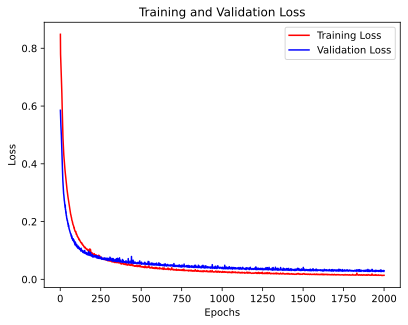

In [15]:
# Access the loss values from the training history.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot of the training and validation loss over epochs.
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,0.01)
plt.legend()

# Step 2: Test the model on unseen data

In [16]:
mom_test = mom_data[n_training_points:n_training_points+n_test_points]
amp_test = amp_data[n_training_points:n_training_points+n_test_points]

In [17]:
mom_test_stdize = standardize(mom_test[:,2:,:],mom_ave, mom_std)                            
amp_pred = np.array(destandardize(model.predict(mom_test_stdize.reshape(-1,input_size)), amp_ave, amp_std)).reshape(-1)

2813/2813 [==============================] - 2s 622us/step


In [18]:
acc = 2.*(amp_pred-amp_test)/(amp_pred+amp_test)

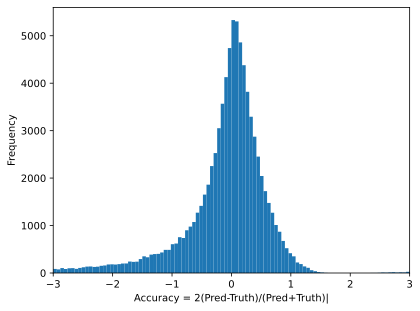

In [19]:
mybins = np.histogram_bin_edges(acc, bins=100, range=(-3,3))
plt.hist(acc, density=False, bins=mybins)
plt.xlim([-3,3])
plt.xlabel('Accuracy = 2(Pred-Truth)/(Pred+Truth)|')
plt.ylabel('Frequency');

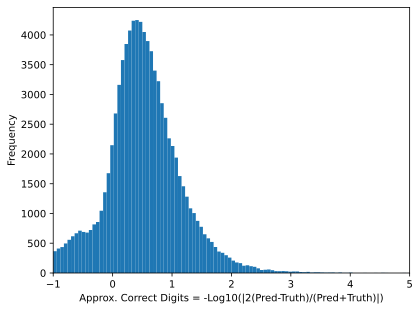

In [20]:
logacc = -np.log10(abs(acc))

mybins = np.histogram_bin_edges(logacc, bins=100, range=(-1,5))
plt.hist(logacc, density=False, bins=mybins)
plt.xlim([-1,5])
plt.xlabel('Approx. Correct Digits = -Log10(|2(Pred-Truth)/(Pred+Truth)|)')
plt.ylabel('Frequency');

# Step 3: Change input data format to use invariants

In [21]:
# another option is to use the 3*n-10 independent invariants as input
# this attempts to account for the Poincare' redundancy in the Lorentz vector representation
def momenta2invariants(mm):
    if len(mm)==4: # s,t
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2])])
    elif len(mm)==5: # s12,s23,s34,s45,s15
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2]),
            dot(mm[2], mm[3]),dot(mm[3], mm[4]),
            dot(mm[4], mm[0])])
    elif len(mm)==6: # s12,s23,s34,s45,s56,s16,s123,s234
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2]),
            dot(mm[2], mm[3]),dot(mm[3], mm[4]),
            dot(mm[4], mm[5]),dot(mm[5], mm[0]),
            dot(mm[0], mm[1])+dot(mm[1], mm[2])+dot(mm[0], mm[2]),
            dot(mm[1], mm[2])+dot(mm[2], mm[3])+dot(mm[1], mm[3])
        ])
    else:
        print("only n = 4,5,6 implemented")
        
    return invariants

In [22]:
inv_train = np.array([momenta2invariants(mm) for mm in mom_train])

In [23]:
# as we are have e+e- with fixed centre-of-mass energy the invariant (p0+p1)^2 = 2*p0.p1 is constant and can be eliminated
inv_ave, inv_std = mean_and_std(inv_train[:,1:],axis=0)
inv_stdized = standardize(inv_train[:,1:], inv_ave, inv_std)

In [24]:
# now set up Keras model with flattened momenta os input values
input_size = len(inv_stdized[0])
input_values = inv_stdized

layers = [20,40,20]

model2 = Sequential()

model2.add(Dense(layers[0], input_dim=(input_size)))
model2.add(Activation(activations.tanh))
        
for layer in range(1, len(layers)):
    model2.add(Dense(layers[layer]))
    model2.add(Activation(activations.tanh))

model2.add(Dense(1))
# Compile model
model2.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss = 'mean_squared_error')

In [25]:
input_train, input_val, output_train, output_val = train_test_split(input_values, amp_stdized, test_size=0.2)

In [26]:
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, restore_best_weights=True)

In [27]:
history = model2.fit(
    input_train, output_train,
    validation_data=(input_val, output_val),
    batch_size=1024, epochs=1000, verbose=0,
    callbacks=[ES]
)

print(f'Best case loss: {ES.best}')

Best case loss: 0.006599471438676119


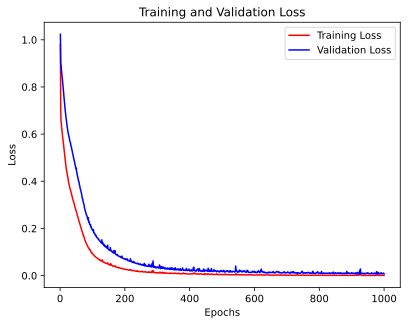

In [28]:
# Access the loss values from the training history.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot of the training and validation loss over epochs.
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,0.01)
plt.legend()

In [29]:
inv_test = np.array([momenta2invariants(mm) for mm in mom_test])
inv_test_stdized = standardize(inv_test[:,1:], inv_ave, inv_std)

In [30]:
amp_pred2 = np.array(destandardize(model2.predict(inv_test_stdized), amp_ave, amp_std)).reshape(-1)

2813/2813 [==============================] - 2s 567us/step


In [31]:
acc2 = 2.*(amp_pred2-amp_test)/(amp_pred2+amp_test)

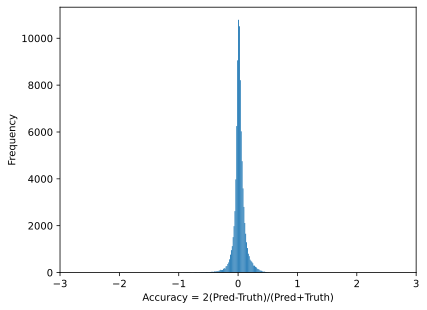

In [32]:
mybins = np.histogram_bin_edges(acc2, bins=400, range=(-3,3))
plt.hist(acc2, density=False, bins=mybins)
plt.xlim([-3,3])
plt.xlabel('Accuracy = 2(Pred-Truth)/(Pred+Truth)')
plt.ylabel('Frequency');

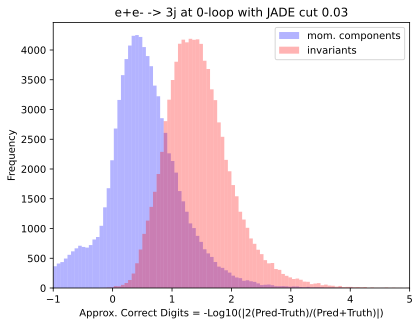

In [33]:
logacc2 = -np.log10(abs(acc2))

mybins = np.histogram_bin_edges(logacc2, bins=100, range=(-1,5))
plt.hist(logacc, density=False, bins=mybins, color='b', alpha=0.3, label='mom. components')
plt.hist(logacc2, density=False, bins=mybins, color='r', alpha=0.3, label='invariants')
plt.xlim([-1,5])
plt.title(r'e+e- -> '+str(jets)+'j at '+str(loop)+'-loop with JADE cut '+str(delta_cut))
plt.xlabel('Approx. Correct Digits = -Log10(|2(Pred-Truth)/(Pred+Truth)|)')
plt.ylabel('Frequency');
plt.legend()

# Step 4: Check the total cross-section #

Let's now check the cross section which for a RAMBO phase-space is defined as (Leading Order)

$\sigma = 1/N_{trials} \sum_p |A(p)|^2$

where $N_{trials}$ is total number of random samples of momenta generated. Since JADE cuts have been applied the number of trials will not be equal to the number of phase-space points. This information was not given with the data set so we won't get the normalisation of the cross-section correct but the convergence cross-section can be tested using the mean value

$\hat{\sigma} = \langle |A(p)|^2 \rangle_p$

with the error estimate given by the standard deviation divided by the square root of the number of points.

In [34]:
# total cross section for the test sample
print("sigma_test = ",np.mean(amp_test),"+/-",np.std(amp_test)/np.sqrt(len(amp_test)))
sigma_ref = np.mean(amp_test)

sigma_test =  0.03676411763100623 +/- 0.00029309218417283454


In [35]:
# total cross section using model 1
print("sigma_pred = ",np.mean(amp_pred),"+/-",np.std(amp_pred)/np.sqrt(len(amp_pred)))
# total cross section using model 2
print("sigma_pred2 = ",np.mean(amp_pred2),"+/-",np.std(amp_pred2)/np.sqrt(len(amp_pred2)))

sigma_pred =  0.036090273 +/- 0.00027905416985352837
sigma_pred2 =  0.037058648 +/- 0.00028768420219421387


In [36]:
# Now plot the cross-section cumilatively for the test set and models 1,2
stepsize = 10000
xs_NJ = [[np.mean(amp_test[0:stepsize*i]), np.std(amp_test[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]
xs_NN1 = [[np.mean(amp_pred[0:stepsize*i]), np.std(amp_pred[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]
xs_NN2 = [[np.mean(amp_pred2[0:stepsize*i]), np.std(amp_pred2[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]

xs_NJ = np.array(xs_NJ)
xs_NN1 = np.array(xs_NN1)
xs_NN2 = np.array(xs_NN2)

In [37]:
# This notation takes every 100 entries in the cumalative less so we don't plot so many points
plotdata1 = xs_NJ[:,0]
plotdata2 = xs_NN1[:,0]
plotdata3 = xs_NN2[:,0]

In [38]:
# check that we did the cumalative average correctly
np.mean(amp_test)-plotdata1[-1]

0.0001483897214496488

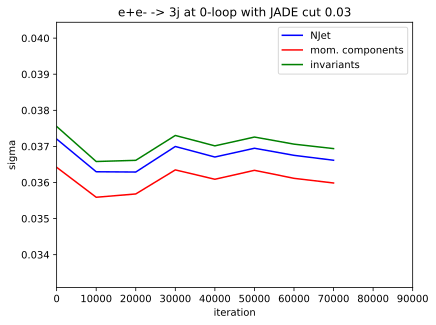

In [39]:
plt.plot(10000*np.array(range(len(plotdata1))), plotdata1, 'b-', label='NJet')
plt.plot(10000*np.array(range(len(plotdata2))), plotdata2, 'r-', label='mom. components')
plt.plot(10000*np.array(range(len(plotdata3))), plotdata3, 'g-', label='invariants')
plt.xlim([0,n_test_points])
plt.ylim([sigma_ref*(1.-0.1),sigma_ref*(1.+0.1)])
plt.ylabel('sigma')
plt.xlabel('iteration');
plt.title(r'e+e- -> '+str(jets)+'j at '+str(loop)+'-loop with JADE cut '+str(delta_cut))
plt.legend()

# Exercises

1. Keeping all the parameters unchanged, re-run the whole notebook. Does it makes sense that we don't get the same answer?
2. Change the number of final state jets and the JADE cut 'delta_cut', does changing the network architecture improve the fit?
3. Choose one-loop e+e- -> 3j and check the performance. Does it match your expectations?
4. Try using dropout to optimize the architecture. You'll need:

 `from tensorflow.keras.layers import Dense, Dropout`

  which may be used as follows
  
 `model = Sequential()`
 
 `model.add(Dense(<layer depth>, activation='relu'))`
 
 `model.add(Dropout(rate=0.5))`
 
 `model.add(Dense(1, activation='relu'))`